TODO:TidyingDemo
* Most common words - minus stop words
* word clouds
* processing for word clouds - stop words, stemming, lowercasing etc
* Mention provided dataset

TODO - time talk

# Twarc Tidying and Analysis
This notebook will cover the exploration, tidying up and some basic analysis of the data collected by the TwarcDemo in this repo(TODO: Link)

We will be using the 100 Vegan Tweets from "Veganuary" 2019. So let's import some packages and read it in.

In [56]:
import pandas as pd # Our data manipulation library
import numpy as np # Support for matrices, and other table-like shapes

In [2]:
# Tweak default plotting styles
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 22,
                    'figure.figsize':(24,8)})

In [3]:
# Read our data into a dataframe using pandas
data = pd.read_csv('data/demoData.csv')

# The head function prints out the first 5 rows.
data.head()

,id,created_at,text,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,...,reply_settings,source,withheld.scope,withheld.copyright,withheld.country_codes,type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 93
0,1088726993405992961,2019-01-25T09:15:17.000Z,Biryani - how is this a biryani? How have @mar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,replied_to,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
1,1090394703466504192,2019-01-29T23:42:10.000Z,@Bash_luiz @marksandspencer Hi Ashley. Biryani...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
2,1090379823271292930,2019-01-29T22:43:02.000Z,Everyone wants to talk about saving the whales...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
3,1090377655424352258,2019-01-29T22:34:25.000Z,I need an emergency escape route to Europe now...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
4,1090374177494876160,2019-01-29T22:20:36.000Z,"""Vegan salads from Sourced Market"" in #London ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,OLIO Articles Plugin,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN


We can actuall test our tweets are real by taking the ID from the first column and replacing the ID in any tweet we can find, which I will demo!

So we've got our data read in successfully, let's print out some of the tweet text to make sure they have something to do with veganism.

In [4]:
for index in [1,2,3,4,5]:
    print(data['text'][index])
    print('\n')


@Bash_luiz @marksandspencer Hi Ashley. Biryani does not "NEED MEAT". Biryani can be made with meat, fish or vegetables all cooked with the same spices. Food in India is flexible between vegetarian and meat dishes.


Everyone wants to talk about saving the whales, using paper straws,  stopping global warming and being environmentally woke, but fail to ACTUALLY do something about it (like going vegan)


I need an emergency escape route to Europe now please! Survival kit must include new job, new home, and hipster vegan coffee places nearby.


"Vegan salads from Sourced Market" in #London #UnitedKingdom https://t.co/1uFTJu6r4S #foodwaste #free


The only type of oil you'll want from now on, this is our vegan chilli oil! 12 hour Sous vide rapeseed oil with fresh chilli and flakes. Drizzled over our lunchbox for the perfect flavour… https://t.co/AG28svsdxf




In [5]:
# I always recommend running info() for basic type information.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 94 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               1328 non-null   int64  
 1   created_at                                       1328 non-null   object 
 2   text                                             1328 non-null   object 
 3   attachments.media                                269 non-null    object 
 4   attachments.media_keys                           269 non-null    object 
 5   attachments.poll.duration_minutes                0 non-null      float64
 6   attachments.poll.end_datetime                    0 non-null      float64
 7   attachments.poll.id                              0 non-null      float64
 8   attachments.poll.options                         0 non-null      float64
 9   attachments.poll.voting_status

In [6]:
# and decribe() for statistical info.
data.describe()

,id,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,author.id,author.entities.description.cashtags,author.pinned_tweet_id,author.public_metrics.followers_count,...,in_reply_to_user.withheld.country_codes,in_reply_to_user_id,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,withheld.scope,withheld.copyright,withheld.country_codes,Unnamed: 93
count,1.328000e+03,0.0,0.0,0.0,0.0,0.0,1.328000e+03,0.0,5.950000e+02,1.328000e+03,...,0.0,3.430000e+02,1328.000000,1328.000000,1328.000000,1328.000000,0.0,0.0,0.0,0.0
mean,1.086664e+18,NaN,NaN,NaN,NaN,NaN,1.668241e+17,NaN,1.235537e+18,7.336349e+04,...,NaN,1.448133e+17,192.410392,25.342620,22.655873,59.442018,NaN,NaN,NaN,NaN
std,1.081035e+16,NaN,NaN,NaN,NaN,NaN,3.454763e+17,NaN,2.090734e+17,7.433436e+05,...,NaN,3.422390e+17,2301.506614,404.263082,167.646396,779.406165,NaN,NaN,NaN,NaN
min,7.635545e+17,NaN,NaN,NaN,NaN,NaN,6.003300e+04,NaN,4.525468e+17,2.000000e+00,...,NaN,6.003300e+04,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,1.085829e+18,NaN,NaN,NaN,NaN,NaN,8.917562e+07,NaN,1.143286e+18,4.130000e+02,...,NaN,6.085304e+07,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,1.087051e+18,NaN,NaN,NaN,NaN,NaN,3.426794e+08,NaN,1.273592e+18,1.089000e+03,...,NaN,2.979902e+08,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,1.088527e+18,NaN,NaN,NaN,NaN,NaN,3.012972e+09,NaN,1.412876e+18,3.165250e+03,...,NaN,2.196203e+09,3.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
max,1.090395e+18,NaN,NaN,NaN,NaN,NaN,1.082757e+18,NaN,1.450341e+18,1.811172e+07,...,NaN,1.082237e+18,55088.000000,11380.000000,3649.000000,19740.000000,NaN,NaN,NaN,NaN


At this point I am thinking we have too many columns to analyse really. It's worth at this point asking if there is anything we could remove now. Though if we are exploring this may be premature.

So that looks good to me, We might notice there are some retweets in here. I personally prefer removing retweets and replies where possible as they complicate our analysis with duplicate and tweets that don't make sense in context.

## Removing retweets and replies.
We need a way of detecting these. You might notice retweets start with two "RT" retweet characters. There is also a column that might help. let's check out the type column.

We can call the value_counts function on any column.

In [7]:
data['type'].value_counts()

replied_to    192
quoted         47
Name: type, dtype: int64

<AxesSubplot:>

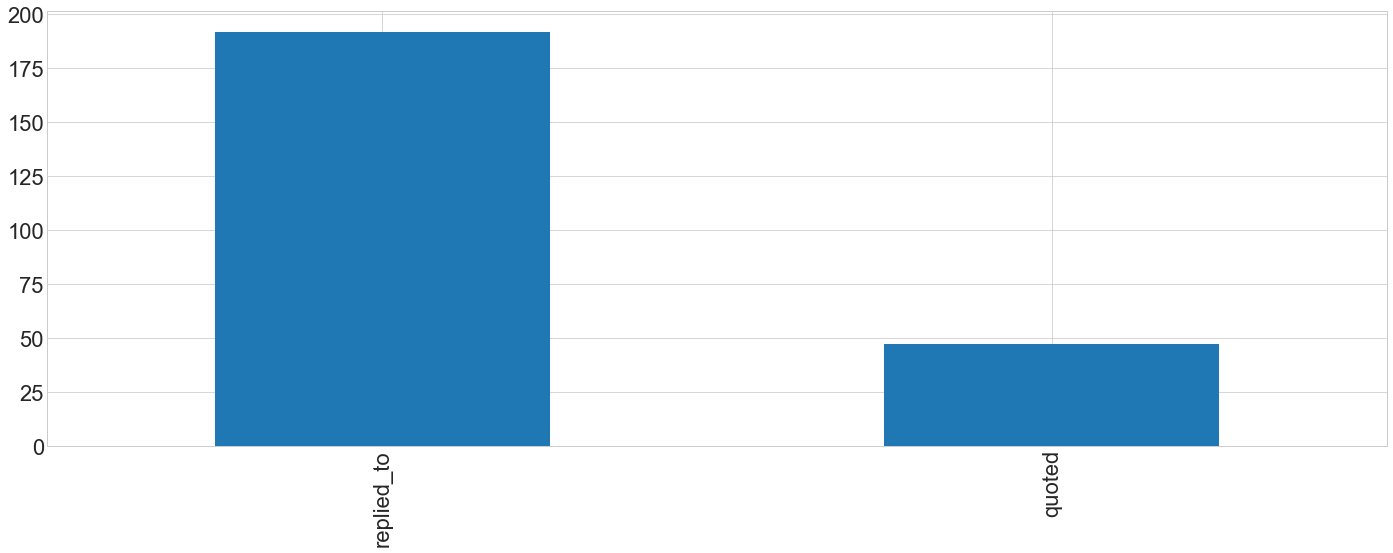

In [8]:
# We can also quickly call a plot function on any of these generated dataframes or value_counts.
data['type'].value_counts().plot(kind='bar')

# Though we are missing lots of Tweets here

In [9]:
# Regular tweets have a type "null"
# We can use boolean indexing to select only the rows that match this null condition.
len(data[data['type'].isnull()])

1089

In [10]:
# so lets select all the tweets that are typed as null.
data = data[data['type'].isnull()]
len(data)

1089

In [11]:
# the length is correct but lets check things look okay
data.head()

,id,created_at,text,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,...,reply_settings,source,withheld.scope,withheld.copyright,withheld.country_codes,type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 93
1,1090394703466504192,2019-01-29T23:42:10.000Z,@Bash_luiz @marksandspencer Hi Ashley. Biryani...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
2,1090379823271292930,2019-01-29T22:43:02.000Z,Everyone wants to talk about saving the whales...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
3,1090377655424352258,2019-01-29T22:34:25.000Z,I need an emergency escape route to Europe now...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Twitter for iPhone,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
4,1090374177494876160,2019-01-29T22:20:36.000Z,"""Vegan salads from Sourced Market"" in #London ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,OLIO Articles Plugin,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN
5,1090371519602143235,2019-01-29T22:10:03.000Z,"The only type of oil you'll want from now on, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,everyone,Instagram,NaN,NaN,NaN,NaN,2021-10-19T09:25:59+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.7.3,NaN


In [12]:
# We need to reindex as well
data = data.reset_index()
# and delete old index
del data['index']

In [13]:
# lets check the first five tweets again
for index in [1,2,3,4,5]:
    print(data['text'][index])
    print('\n')

Everyone wants to talk about saving the whales, using paper straws,  stopping global warming and being environmentally woke, but fail to ACTUALLY do something about it (like going vegan)


I need an emergency escape route to Europe now please! Survival kit must include new job, new home, and hipster vegan coffee places nearby.


"Vegan salads from Sourced Market" in #London #UnitedKingdom https://t.co/1uFTJu6r4S #foodwaste #free


The only type of oil you'll want from now on, this is our vegan chilli oil! 12 hour Sous vide rapeseed oil with fresh chilli and flakes. Drizzled over our lunchbox for the perfect flavour… https://t.co/AG28svsdxf


We are pleased to announce that our truly fabulous tutor Elaine (of Very Vegan Cakes) will be running an adult vegan baking class at @thecookingshed Book your space at https://t.co/Azk3lX7jPo #vegan #veganclass #veganbaking #veganbakingclass #cookeryclass #bromley #cookeryschool https://t.co/A7n8AEjlqj




Annoyingly removing tweets marked with type retweet doesn't seem to get them all. This is one of those many things with the Twitter API I can't seem to find an answer to.

Luckily they are prepended with RT, which we can scrape an remove.

In [14]:
# remove tweets with RT string
data = data[~data['text'].str.contains('RT')]

In [15]:
# again, reset index and let's test again.
data = data.reset_index()

del data['index']

# lets check the first five tweets again
for index in [1,2,3,4,5]:
    print(data['text'][index])
    print('\n')

Everyone wants to talk about saving the whales, using paper straws,  stopping global warming and being environmentally woke, but fail to ACTUALLY do something about it (like going vegan)


I need an emergency escape route to Europe now please! Survival kit must include new job, new home, and hipster vegan coffee places nearby.


"Vegan salads from Sourced Market" in #London #UnitedKingdom https://t.co/1uFTJu6r4S #foodwaste #free


The only type of oil you'll want from now on, this is our vegan chilli oil! 12 hour Sous vide rapeseed oil with fresh chilli and flakes. Drizzled over our lunchbox for the perfect flavour… https://t.co/AG28svsdxf


We are pleased to announce that our truly fabulous tutor Elaine (of Very Vegan Cakes) will be running an adult vegan baking class at @thecookingshed Book your space at https://t.co/Azk3lX7jPo #vegan #veganclass #veganbaking #veganbakingclass #cookeryclass #bromley #cookeryschool https://t.co/A7n8AEjlqj




At this point it's probably time to narrow down what we are doing, there is too much interesting information in this dataset.

I am going to keep the following:
* id - The Tweet ID
* created_at - The time the tweet was created
* text - the text that makes up a tweet
* author.id - the author ID
* author.created_at - when the users account was created
* author.username - the Twitter users username
* author.location - a self-defined location
* author.public_metrics.followers_count - Number of followers a user has
* geo.full_name - the full name describing a tweets geolocation
* public_metrics.like_count - number of likes on this tweet
* public_metrics.retweet_count - number of retweets on this tweer.

In [16]:
data = data[['id','created_at', 'text','author.id','author.created_at', 'author.username','author.location','author.public_metrics.followers_count','geo.full_name','public_metrics.like_count','public_metrics.retweet_count']]
data.head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count
0,1090394703466504192,2019-01-29T23:42:10.000Z,@Bash_luiz @marksandspencer Hi Ashley. Biryani...,38245559,2009-05-06T18:40:46.000Z,katrinamirpuri,"London, England",808,"London, England",6,0
1,1090379823271292930,2019-01-29T22:43:02.000Z,Everyone wants to talk about saving the whales...,883445928,2012-10-16T01:37:11.000Z,drinkfallhealy,Chicago,3796,"Islington, London",1,0
2,1090377655424352258,2019-01-29T22:34:25.000Z,I need an emergency escape route to Europe now...,248448795,2011-02-07T01:13:26.000Z,mufseen,London,19993,"Greenwich, London",10,1
3,1090374177494876160,2019-01-29T22:20:36.000Z,"""Vegan salads from Sourced Market"" in #London ...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Walthamstow, London",0,0
4,1090371519602143235,2019-01-29T22:10:03.000Z,"The only type of oil you'll want from now on, ...",3144635056,2015-04-07T16:46:00.000Z,biandangUk,"London, England",923,"Poplar, London",0,0


## How is Veganism percieved on Twitter?
In order to answer this question we need to introduce sentiment analysis. This is quite easy to do in Python as complicated as it sounds. As with many complicated things, somebody has written a package to make this easy for us.


In [17]:
# Import NLTK, the Natural Language package
import nltk
# Download the popular vader lexicon of words and sentiments.
nltk.download([
    "vader_lexicon",
])

# import the sentiment analyser.
from nltk.sentiment import SentimentIntensityAnalyzer

# Create a new sentiment analyser.
sia = SentimentIntensityAnalyzer()

# And write a function we can pass to our pandas function
def get_sentiment(string):
    return sia.polarity_scores(string)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


With this package our sentiment scores are returned on a scale of -1 for fully negative, to +1 for fully positive.
So our below sentence "I love cats" has a sentiment of 0.6, we high positive sentiment. Whereas "I hate cats is lower in sentiment.

In [18]:
# Test our sentiment package
get_sentiment('I love cats')

0.6369

In [19]:
# Test our sentiment package
get_sentiment('I hate cats')

-0.5719

In [20]:
# So let's apply this to our entire dataframe
data['sentiment'] = data['text'].apply(get_sentiment)

# print a few rows
for index in [1,2,3,4,5]:
    print('sentiment ' + str(data['sentiment'][index]))
    print(data['text'][index])
    print('\n')

sentiment -0.6956
Everyone wants to talk about saving the whales, using paper straws,  stopping global warming and being environmentally woke, but fail to ACTUALLY do something about it (like going vegan)


sentiment 0.1759
I need an emergency escape route to Europe now please! Survival kit must include new job, new home, and hipster vegan coffee places nearby.


sentiment 0.0
"Vegan salads from Sourced Market" in #London #UnitedKingdom https://t.co/1uFTJu6r4S #foodwaste #free


sentiment 0.7644
The only type of oil you'll want from now on, this is our vegan chilli oil! 12 hour Sous vide rapeseed oil with fresh chilli and flakes. Drizzled over our lunchbox for the perfect flavour… https://t.co/AG28svsdxf


sentiment 0.8481
We are pleased to announce that our truly fabulous tutor Elaine (of Very Vegan Cakes) will be running an adult vegan baking class at @thecookingshed Book your space at https://t.co/Azk3lX7jPo #vegan #veganclass #veganbaking #veganbakingclass #cookeryclass #bromley #c

### What can we do with our sentiment scores
To start with, let's find our highest sentiment tweet.


In [21]:
data.sort_values(by='sentiment', ascending=False).head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
156,1089248126773399554,2019-01-26T19:46:05.000Z,Enjoyed a lovely vegetarian meal @unwinedsw17 ...,975293603479281664,2018-03-18T08:51:29.000Z,Yogawithdianas1,"Tooting, London",160,"Wandsworth, London",1,0,0.9690
416,1087737416042115073,2019-01-22T15:43:03.000Z,Oscar nominations may be out but we have our o...,777574689292058624,2016-09-18T18:27:07.000Z,TamuApp,"London, England",106,"London, England",8,1,0.9671
407,1087769294602190848,2019-01-22T17:49:44.000Z,Had an amazing meal and coffee at this awesome...,283141949,2011-04-16T17:24:36.000Z,TheEmmaBryant,THE SHARD!!!!!!!!!!!!!!!!!!!!!,33981,"Poplar, London",1,1,0.9628
785,1085931874768187392,2019-01-17T16:08:29.000Z,Let’s make fresh Ramen noodles! We had such f...,215237826,2010-11-13T11:13:47.000Z,hashicooking,SW London,1889,"Merton, London",0,0,0.9613
254,1088766510292701185,2019-01-25T11:52:19.000Z,"💙 Happy Friday! May your weekend be happy, hea...",791408393961570304,2016-10-26T22:37:19.000Z,NazaniTea,"London, England",923,"Kensington, London",5,1,0.9611


In [22]:
topSentimentIndex = 156
print(data['id'][topSentimentIndex])
print(data['text'][topSentimentIndex])
print(data['sentiment'][topSentimentIndex])

1089248126773399554
Enjoyed a lovely vegetarian meal @unwinedsw17   Definitely recommend this friendly local wine bar. We always feel welcome and the food and wine have been a pleasure for the taste buds.… https://t.co/vmYheuV6Mm
0.969


In [23]:
# And how about the lowest sentiment?
data.sort_values(by='sentiment', ascending=True).head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
104,1089654135962718208,2019-01-27T22:39:25.000Z,Im not officially #Vegan but I just tried to e...,1068315866956263424,2018-11-30T01:28:45.000Z,CAnnagay,"London, England",91,"Merton, London",1,0,-0.9186
571,1087024957194989574,2019-01-20T16:32:00.000Z,@KezzerN @clairelbob @ChrisGPackham @WeAreVega...,591857988,2012-05-27T12:15:54.000Z,sojourner337,"London, England",4212,"Richmond, London",0,0,-0.9053
504,1087304935539204097,2019-01-21T11:04:32.000Z,@Kevinodowd5 @BiggiBK Thank you for this tweet...,18094988,2008-12-13T06:32:31.000Z,lboliver,"Lewisville, TX",44,"Camberwell, London",0,0,-0.8957
722,1086205473362272258,2019-01-18T10:15:40.000Z,No offence but vegetarians are killing the ani...,42306096,2009-05-24T23:46:34.000Z,Gcooler,London,1810,"Islington, London",2,0,-0.8519
732,1086180804198313984,2019-01-18T08:37:38.000Z,@ProfTimNoakes What this basically means is th...,244582725,2011-01-29T17:00:39.000Z,wyadvd,uk,2548,"Lambeth, London",8,0,-0.8500


In [24]:
bottomSentimentIndex = 104
print(data['id'][bottomSentimentIndex])
print(data['text'][bottomSentimentIndex])
print(data['sentiment'][bottomSentimentIndex])

1089654135962718208
Im not officially #Vegan but I just tried to eat some chicken and every bite i was thinking Im eating flesh that could have diseases in it or the way it was killed was probably painful  what better am I to a cannibal only difference is I cook the meat and someone else kills it. https://t.co/PzL6m3j9Cb
-0.9186


In [25]:
# Let's also grab some neutral tweets.
data[data['sentiment'] == 0]

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
3,1090374177494876160,2019-01-29T22:20:36.000Z,"""Vegan salads from Sourced Market"" in #London ...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Walthamstow, London",0,0,0.0
10,1090342101752078336,2019-01-29T20:13:09.000Z,Another day another plant based meal. Curried...,817373062828032000,2017-01-06T14:11:39.000Z,LinaLeaner,"London, England",29,"London, England",1,0,0.0
15,1090321253142016000,2019-01-29T18:50:18.000Z,my vegan meal incorporated with my 1:1 diet by...,237909608,2011-01-13T22:48:15.000Z,CWPBITS,LONDON,94,"Barnet, London",0,0,0.0
16,1090314604238925824,2019-01-29T18:23:53.000Z,Throw back to last week's dinner. What is your...,4766828133,2016-01-10T18:58:19.000Z,InspiredByVu,"London, England",59,"Camberwell, London",1,0,0.0
19,1090299404718874625,2019-01-29T17:23:29.000Z,Gunna make vegan meatballs and spaghetti for d...,2962920022,2015-01-05T22:38:04.000Z,EvieLouise44,"London, England",137,"Ealing, London",1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1071,1084561207288315905,2019-01-13T21:21:56.000Z,GF Southern Fried Vegan Bites 🌱 https://t.co/u...,1074394357200027653,2018-12-16T20:02:30.000Z,CoupleaVeganz,London/Kent,45,"London, England",2,0,0.0
1073,1084557255327039488,2019-01-13T21:06:14.000Z,"""UPDATED Sushi (Vegan or Fish)"" in #London #U...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0
1074,1084556840908787722,2019-01-13T21:04:35.000Z,"""Vegetarian/Meat Based items - First To Messag...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0
1077,1084553791473704961,2019-01-13T20:52:28.000Z,"""UPDATED Raw, Vegan Pronuts (like protein ball...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0


In [26]:
neutralIndex = 3
print(data['id'][neutralIndex])
print(data['text'][neutralIndex])
print(data['sentiment'][neutralIndex])

1090374177494876160
"Vegan salads from Sourced Market" in #London #UnitedKingdom https://t.co/1uFTJu6r4S #foodwaste #free
0.0


<AxesSubplot:>

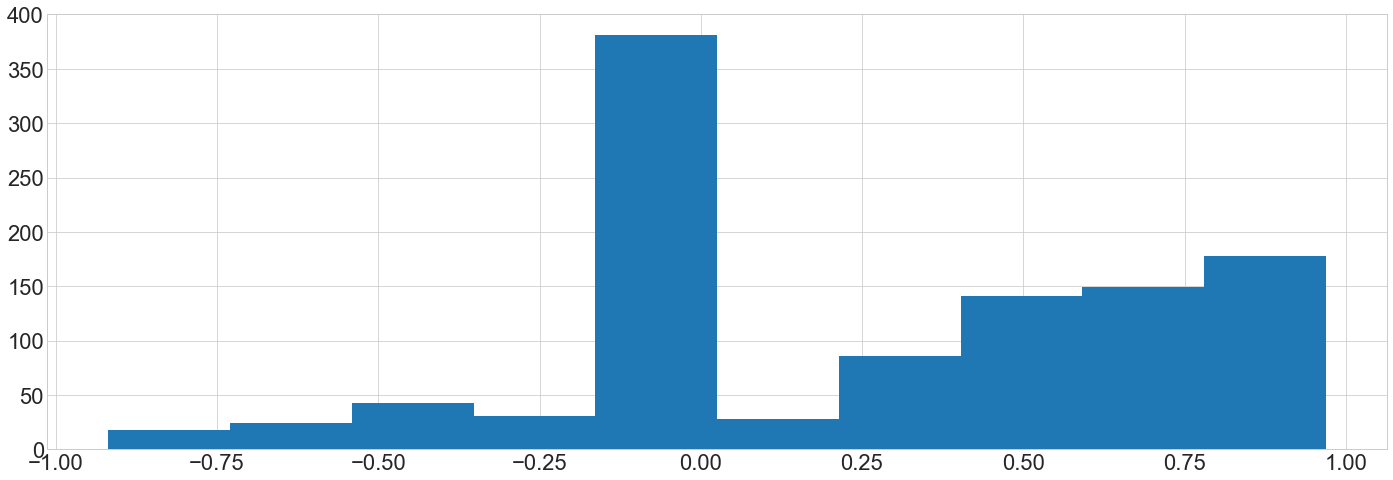

In [27]:
# Often the users at each end of this spectrum are quite different, lets see what our tweeters look like in general
data.sentiment.hist()

At a glance there are three different kinds of tweets here:
1. Negative tweets, these are likely complaints from vegans or complaints about vegans.
2. Neutral tweets, Most of the users appear to be neutral, this is usually a symptom that our sentiment analyser wasn't trained on the language it's predicting on, so is seeing words it's never classified before and tags them as neutral.
3. Positive tweets, these appear in abundance in comparison to negativity. Could this be a sign of positivity, marketing, bias?

On a hunch this grouping is quite naive. I could imagine a big difference in group 1:
* People complaining about vegans in a hateful way
* Vegans complaining about non-vegans in a hateful way
* Vegans complaining about vegan difficulties.

group 3 likely contains:
* Inflated self-promotion from vegan business owners
* Inflated promotion and feedback from large brands launching vegan products such as Greggs and the Vegan sausage roll.

These are all much larger project ideas, we don't even have a level of condience that any of these users are vegan.

### Most liked content
We have access to likes and retweets, let's check out what the most liked content is.

<AxesSubplot:>

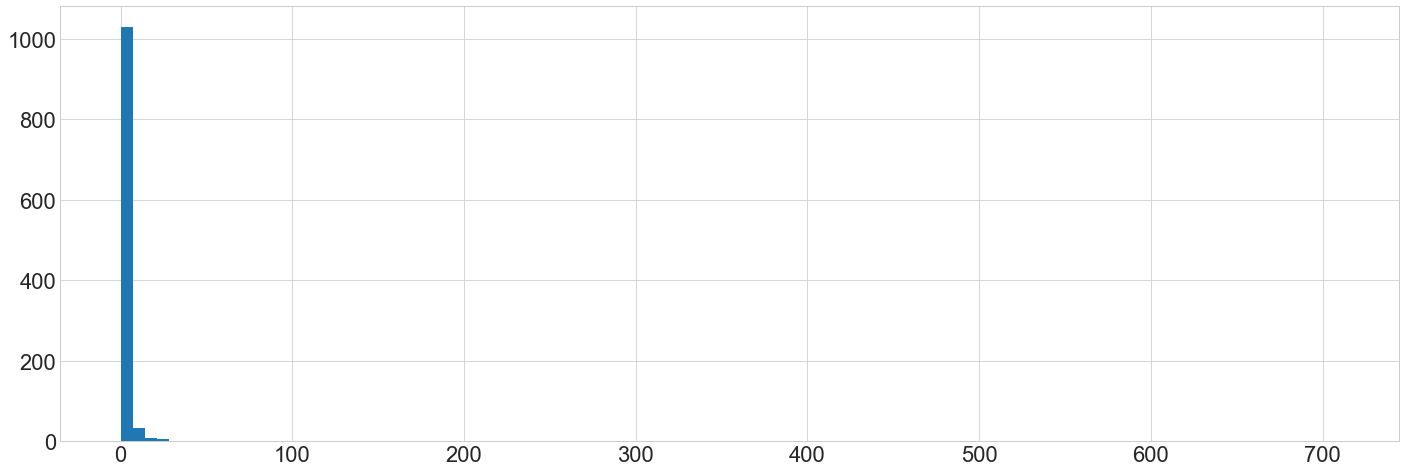

In [28]:
# A fairly familiar graph of likes being geometrically hard to gain, with outliers from "viral" tweets
data['public_metrics.like_count'].hist(bins=100)

<AxesSubplot:>

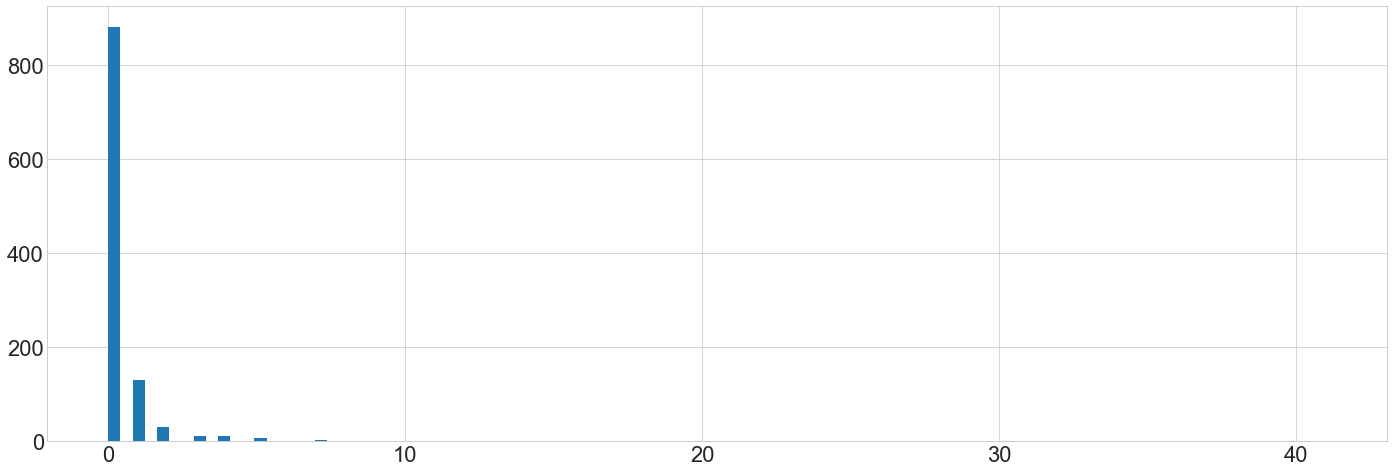

In [29]:
# And we see similar with retweets, even harder to come by as an echo of messaging rather than approval.
data['public_metrics.retweet_count'].hist(bins=100)

In [30]:
# And how about the lowest sentiment?
data.sort_values(by='public_metrics.like_count', ascending=False).head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
1012,1084877287810629632,2019-01-14T18:17:56.000Z,Made the most amazing cauliflower mash today. ...,149103331,2010-05-28T12:27:27.000Z,BoyGeorge,"London, England",475242,"Camden Town, London",709,41,-0.2838
797,1085885027349610496,2019-01-17T13:02:19.000Z,@SoVeryBritish I’m Vegan 🤮🤢,26025336,2009-03-23T15:46:57.000Z,coulson3000,"London, England",661,"Lewisham, London",197,0,0.0000
50,1090168196785729537,2019-01-29T08:42:07.000Z,Eating more plants and less meat is still an a...,1474925190,2013-06-01T15:12:07.000Z,Rhitrition,"Harley Street, London",18889,"Paddington, London",45,7,0.4840
245,1088793419240165376,2019-01-25T13:39:14.000Z,My mum’s in London for the day and I’ve brough...,187490279,2010-09-06T11:25:55.000Z,MattCainWriter,London,12675,"London, England",40,0,0.2598
982,1085087200516235265,2019-01-15T08:12:03.000Z,Smoked split mung beans. #winterwarmers #Vegan...,203677931,2010-10-16T21:08:27.000Z,Anjuladevi,Hampton,12375,"Richmond, London",31,4,0.0000


In [31]:
mostLikedIndex = 1012
print(data['id'][mostLikedIndex])
print(data['text'][mostLikedIndex])
print(data['sentiment'][mostLikedIndex])

1084877287810629632
Made the most amazing cauliflower mash today. Veggie not vegan but thanks to @ChefTomKerridge I used the green parts, steamed them with the cauliflower and blended the lot with butter &amp; cream. Tsp of mustard. S&amp;P! Mmm!
-0.2838


In [32]:
# And how about the most retweeted?
data.sort_values(by='public_metrics.retweet_count', ascending=False).head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
1012,1084877287810629632,2019-01-14T18:17:56.000Z,Made the most amazing cauliflower mash today. ...,149103331,2010-05-28T12:27:27.000Z,BoyGeorge,"London, England",475242,"Camden Town, London",709,41,-0.2838
71,1089977602775896064,2019-01-28T20:04:45.000Z,"Yard long beans, string beans, sprouting mung ...",203677931,2010-10-16T21:08:27.000Z,Anjuladevi,Hampton,12375,"Richmond, London",28,8,0.0000
50,1090168196785729537,2019-01-29T08:42:07.000Z,Eating more plants and less meat is still an a...,1474925190,2013-06-01T15:12:07.000Z,Rhitrition,"Harley Street, London",18889,"Paddington, London",45,7,0.4840
975,1085111799408672768,2019-01-15T09:49:48.000Z,PwC staff go #vegan for the #VeganuaryWorkplac...,339941459,2011-07-21T22:18:53.000Z,RobMcCargow,Born @ 333.13ppm 🌍,18005,"London, England",22,7,0.0000
480,1087382919797264384,2019-01-21T16:14:25.000Z,I had the most wonderful time @waitrose #Vegan...,819623564601098242,2017-01-12T19:14:20.000Z,Aaronvegan,"Brighton, England",2828,"Lewisham, London",18,7,0.6115


In [33]:
mostRetweetedIndex = 1012
print(data['id'][mostRetweetedIndex])
print(data['text'][mostRetweetedIndex])
print(data['sentiment'][mostRetweetedIndex])

1084877287810629632
Made the most amazing cauliflower mash today. Veggie not vegan but thanks to @ChefTomKerridge I used the green parts, steamed them with the cauliflower and blended the lot with butter &amp; cream. Tsp of mustard. S&amp;P! Mmm!
-0.2838


The most liked and most retweeted came from Boy George, there is a correlation there that we will look at later.

## Does the perception of Veganism change over time?
This is a toy example of what we saw in the presentation. How do we percieve a rolling sentiment over time.

Next let's sort this dataframe by date. Looking now we seem to have only a handful of minutes between our Tweets.

In [34]:
# sort by date
# convert created at into a datetime object
data['created_at'] =pd.to_datetime(data.created_at)
# Sort our dataframe b dates
data = data.sort_values(by='created_at',ascending=True)
# reset index
data = data.reset_index()
del data['index']

# print the head
data.head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count,sentiment
0,1084550382326550531,2019-01-13 20:38:55+00:00,"""Wholesome Organic Bread (GF, WF, Vegan option...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0000
1,1084553791473704961,2019-01-13 20:52:28+00:00,"""UPDATED Raw, Vegan Pronuts (like protein ball...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0000
2,1084554888527388672,2019-01-13 20:56:50+00:00,@JoannaBlythman @mistereatgalway Imagine how i...,943146855340347392,2017-12-19T15:51:47.000Z,ethical_butcher,"London, England",3737,"Kensington, London",5,0,-0.3818
3,1084555832212291585,2019-01-13 21:00:35+00:00,@bigfatsurprise Imagine how it is for us pitch...,943146855340347392,2017-12-19T15:51:47.000Z,ethical_butcher,"London, England",3737,"Kensington, London",0,0,-0.3818
4,1084556840908787722,2019-01-13 21:04:35+00:00,"""Vegetarian/Meat Based items - First To Messag...",824637752574488576,2017-01-26T15:18:56.000Z,WhatsOnOLIO,NaN,1089,"Paddington, London",0,0,0.0000


<AxesSubplot:>

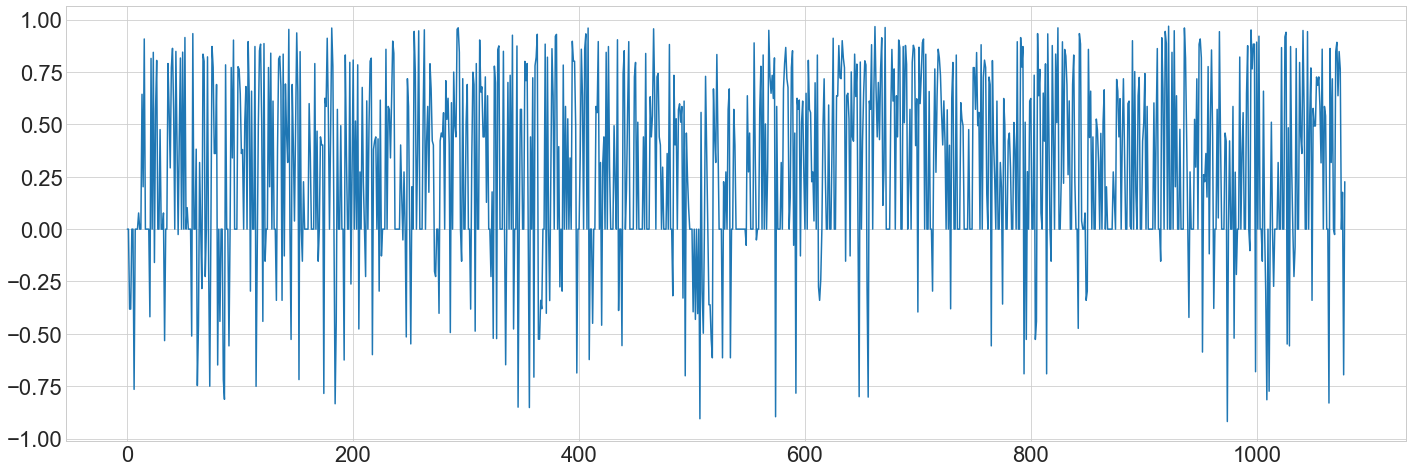

In [35]:
# To start with let's plot sentiment over index. Although this is linear, rather than time based it can be useful.
data['sentiment'].plot()

<AxesSubplot:>

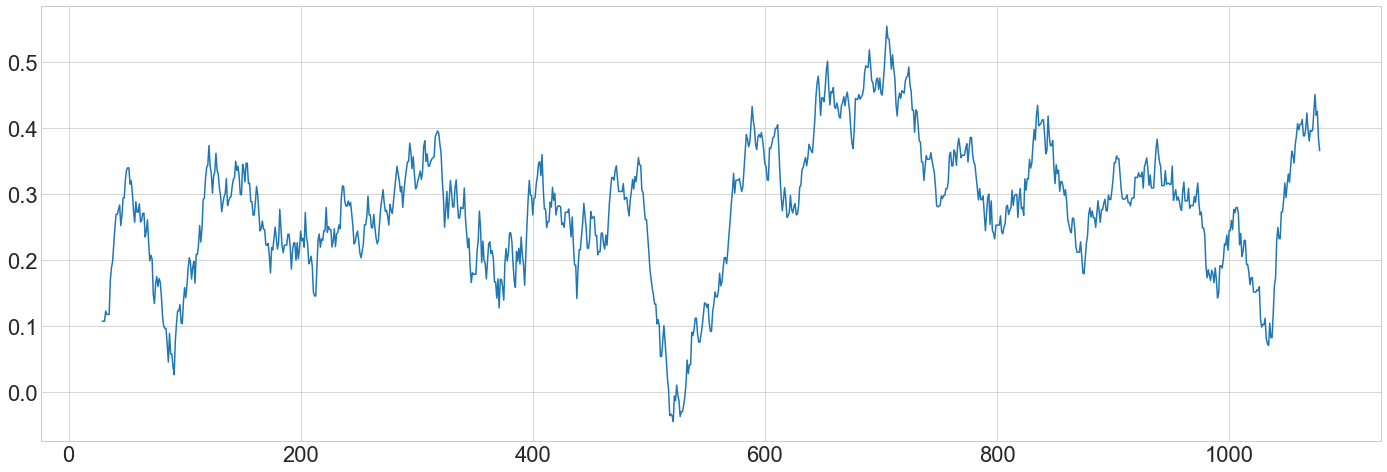

In [36]:
# As each tweet is relatively unconnected we can get quite erratic plots, some smoothin can help.
data['sentiment'].rolling(30).mean().plot()

<AxesSubplot:>

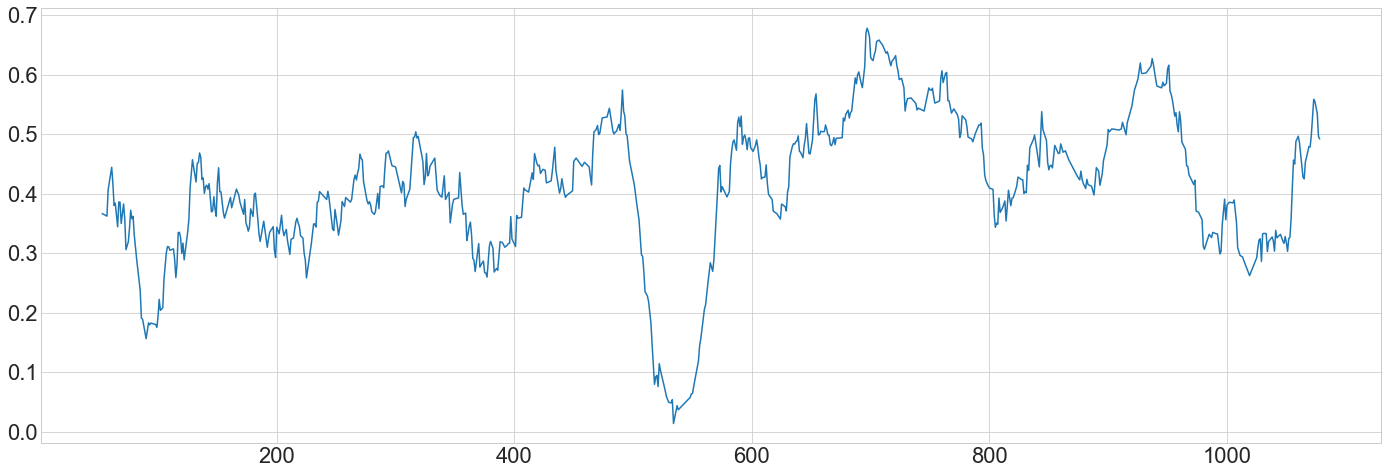

In [54]:
# Our neutral tweets, generally introduce some high-sentiment content that our model doesn't understand yet, so maybe we should remove them.
data[data.sentiment != 0]['sentiment'].rolling(30).mean().plot()

<AxesSubplot:xlabel='created_at', ylabel='sentiment'>

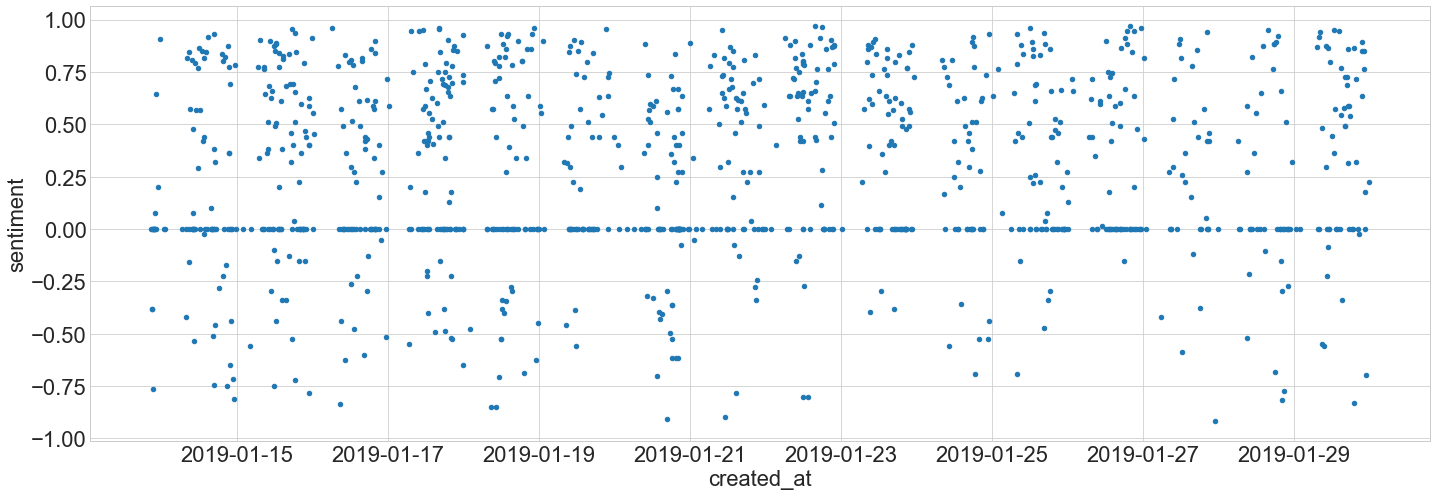

In [49]:
# plot with realistic time axis
data.plot(kind='scatter',x='created_at', y='sentiment')

As we are only looking at such a small sample it's hard to draw any conclusions from this data. Depending on what we follow this can be a very clear line that somewhat represents the sentiment of a topic over time. Diving into our neutral tweets to better classify could be a good next step.

### Does sentiment correlate with success?
Now we have quantified sentiment, do high sentiment messages get engagement?
Let's plot our:
* follower counts
* likes count
* retweet count
* sentiment 

And see what we find.

In [60]:
corr = data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count','sentiment']].corr()
corr.style.background_gradient(cmap ='coolwarm')

,author.public_metrics.followers_count,public_metrics.like_count,public_metrics.retweet_count,sentiment
author.public_metrics.followers_count,1.000000,0.245544,0.189450,0.008179
public_metrics.like_count,0.245544,1.000000,0.817724,-0.038469
public_metrics.retweet_count,0.189450,0.817724,1.000000,0.018819
sentiment,0.008179,-0.038469,0.018819,1.000000


My hunch is that as so many results have neutral sentiment this is probably shifting our correlations quite heavily, let's remove them for now.

In [61]:
corr = data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count','sentiment']][data['sentiment'] != 0].corr()
corr.style.background_gradient(cmap ='coolwarm')

,author.public_metrics.followers_count,public_metrics.like_count,public_metrics.retweet_count,sentiment
author.public_metrics.followers_count,1.000000,0.342911,0.276690,0.019827
public_metrics.like_count,0.342911,1.000000,0.879998,-0.051241
public_metrics.retweet_count,0.276690,0.879998,1.000000,0.001712
sentiment,0.019827,-0.051241,0.001712,1.000000


It seems that the more followers a user has, the more likely their content is to be liked and retweeted. Follower count does not correlate with the sentiment of tweets though.

Likes and retweets have a strong correlation, content that is likely to be retweeted is also likely to be liked.

In this case sentiment doesn't seem to correlate with any of these features though.

## TODO: Most common words - out of scope? Maybe a Future Projects section?
By this point, we have noticed that our neutral sentiment tweets are a bit of a missed oppurtunity. We understand sentiment generally, but do not understand the terms within our topic area. The word "carnivore" might be usual, but in vegan circles it can be used in disgust or even as an insult, our sentiment analyzer doesn't understand this.

Let's take a look at what sorts of words show up in abundance in our content.

TODO:
* Get word counts
* Deal with stop words
* Find duplicates of words thorugh case sensitivity, spellcheck and stemming
* Make word clouds, demo wordcloud website too